In [ ]:
# Install required libraries
!pip install pandas numpy scikit-learn matplotlib seaborn xgboost lightgbm catboost shap


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.6 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, f1_score
import shap

In [4]:
# Load the dataset
data = pd.read_csv('/content/events.csv')

In [ ]:
print(data.info())
print(data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 721280 entries, 0 to 721279
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   event_time     721280 non-null  object 
 1   event_type     721280 non-null  object 
 2   product_id     721280 non-null  int64  
 3   category_id    721280 non-null  int64  
 4   category_code  524915 non-null  object 
 5   brand          546701 non-null  object 
 6   price          721279 non-null  float64
 7   user_id        721279 non-null  float64
 8   user_session   721121 non-null  object 
dtypes: float64(2), int64(2), object(5)
memory usage: 49.5+ MB
None
                event_time event_type  product_id          category_id  \
0  2020-09-24 11:57:06 UTC       view     1996170  2144415922528452715   
1  2020-09-24 11:57:26 UTC       view      139905  2144415926932472027   
2  2020-09-24 11:57:27 UTC       view      215454  2144415927158964449   
3  2020-09-24 11:57:33 UTC     

In [6]:
# Parse event_time to datetime and clean data
data['event_time'] = pd.to_datetime(data['event_time'])
data.fillna({'category_code': 'unknown', 'brand': 'unknown'}, inplace=True)
data.drop_duplicates(inplace=True)

In [7]:
data = data.drop_duplicates()


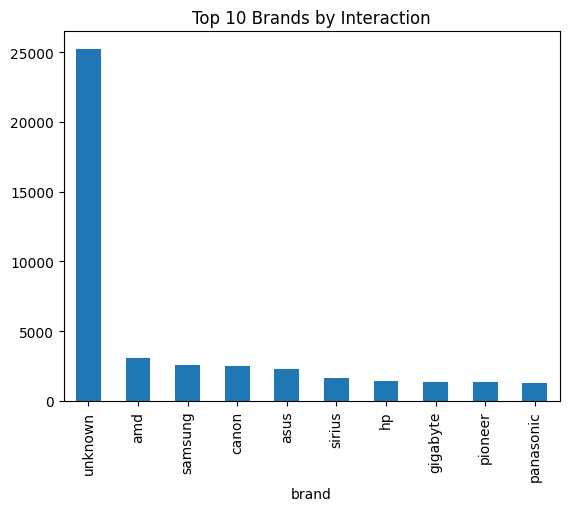

In [9]:
# Brand popularity
top_brands = data['brand'].value_counts().head(10)
top_brands.plot(kind='bar')
plt.title("Top 10 Brands by Interaction")
plt.show()

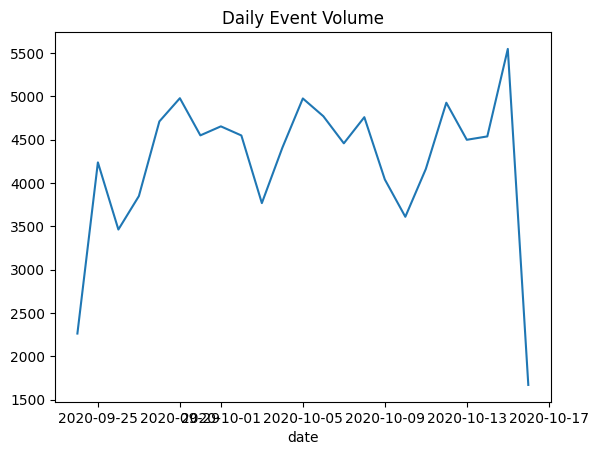

In [10]:
data['date'] = data['event_time'].dt.date
daily_events = data.groupby('date').size()
daily_events.plot(kind='line')
plt.title("Daily Event Volume")
plt.show()

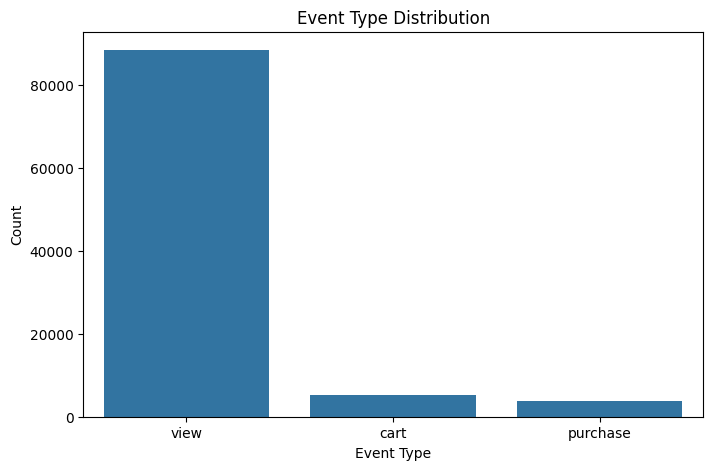

In [11]:
# Event type distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='event_type', data=data, order=data['event_type'].value_counts().index)
plt.title('Event Type Distribution')
plt.xlabel('Event Type')
plt.ylabel('Count')
plt.show()

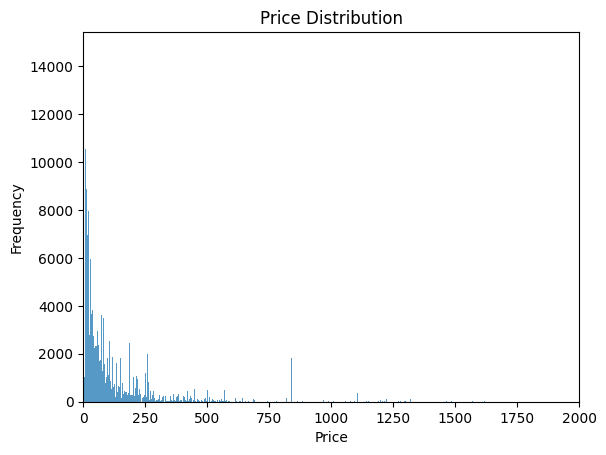

In [9]:
# Price distribution
sns.histplot(data['price'], bins = 100000)
plt.title('Price Distribution')
plt.xlabel('Price')
plt.xlim(0, 2000)
plt.ylabel('Frequency')
plt.show()

<Figure size 800x500 with 0 Axes>

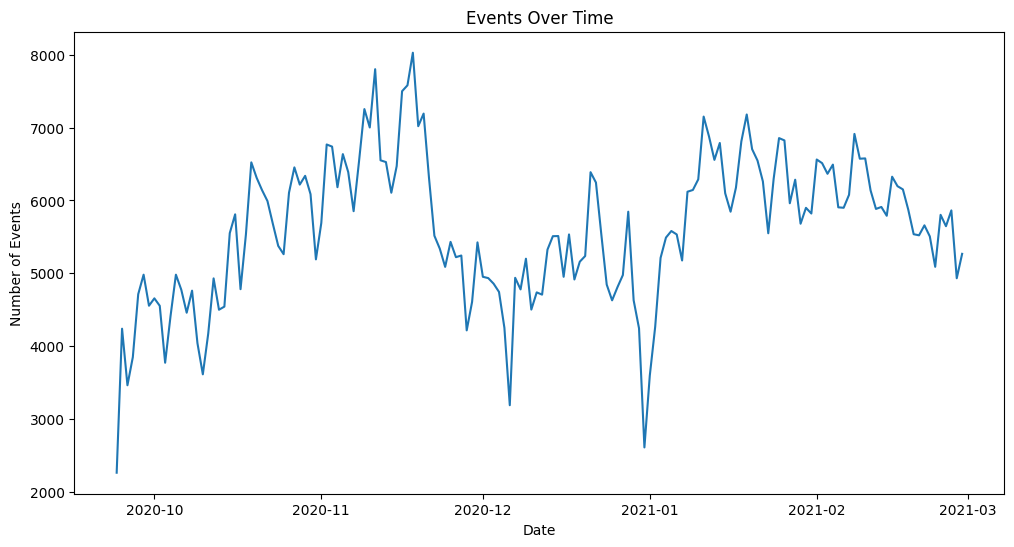

In [10]:
plt.figure(figsize=(8, 5))
if not pd.api.types.is_datetime64_any_dtype(data['event_time']):
    data['event_time'] = pd.to_datetime(data['event_time'])
data['event_date'] = data['event_time'].dt.date
plt.figure(figsize=(12, 6))
data.groupby('event_date')['event_type'].count().plot()
plt.title('Events Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Events')
plt.show()


In [18]:
# Defining Churn
churn_threshold_date = data['event_time'].max() - timedelta(days=30)
last_event = data.groupby('user_id')['event_time'].max().reset_index()
last_event['is_churned'] = last_event['event_time'] < churn_threshold_date

# Create user_churn_status mapping
user_churn_status = dict(zip(last_event['user_id'], last_event['is_churned']))

latest_event_time = data['event_time'].max()

user_features = data.groupby('user_id').agg(
    recency=('event_time', lambda x: (latest_event_time - x.max()).days), # Now latest_event_time is defined
    frequency=('user_session', 'nunique'),
    monetary=('price', 'sum'),
    view_count=('event_type', lambda x: (x == 'view').sum()),
    cart_count=('event_type', lambda x: (x == 'cart').sum()),
    purchase_count=('event_type', lambda x: (x == 'purchase').sum())
)

# Behavioral Ratios
user_features['view_to_cart_ratio'] = user_features['cart_count'] / (user_features['view_count'] + 1)
user_features['cart_to_purchase_ratio'] = user_features['purchase_count'] / (user_features['cart_count'] + 1)

# Add churn labels using the mapping
user_features['is_churned'] = user_features.index.map(user_churn_status)
print(user_features.head())

                     recency  frequency  monetary  view_count  cart_count  \
user_id                                                                     
1515915625353226922      122          1     76.48           1           0   
1515915625353230067      145          1     28.98           1           0   
1515915625353230683       78          4    814.93          13           0   
1515915625353230922      149          1    274.40           1           0   
1515915625353234047       10          1   5481.90          36           0   

                     purchase_count  view_to_cart_ratio  \
user_id                                                   
1515915625353226922               0                 0.0   
1515915625353230067               0                 0.0   
1515915625353230683               0                 0.0   
1515915625353230922               0                 0.0   
1515915625353234047               0                 0.0   

                     cart_to_purchase_ratio  i

In [19]:
# Defining Churn
churn_threshold_date = data['event_time'].max() - timedelta(days=30)
last_event = data.groupby('user_id')['event_time'].max().reset_index()
last_event['is_churned'] = last_event['event_time'] < churn_threshold_date
user_features = user_features.merge(last_event[['user_id', 'is_churned']], on='user_id', how='left')


In [22]:
user_features = user_features.reset_index()
X = user_features.drop(columns=['user_id', 'is_churned_y'])
y = user_features['is_churned_x']  # Target variable is now 'is_churned_x'
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [28]:
!pip install catboost
from lightgbm import LGBMClassifier # This line imports LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.6 MB/s eta 0:00:00


In [29]:
# Train various models
models = {
    "RandomForest": RandomForestClassifier(random_state=42, n_estimators=100),
    "XGBoost": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
    "LightGBM": LGBMClassifier(random_state=42),
    "CatBoost": CatBoostClassifier(random_state=42, verbose=0),
    "GradientBoosting": GradientBoostingClassifier(random_state=42)
}

# Evaluate each model
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    print(f"--- {name} ---")
    print(classification_report(y_test, y_pred))
    print("AUC-ROC:", roc_auc_score(y_test, y_proba))
    print()


--- RandomForest ---
              precision    recall  f1-score   support

       False       1.00      1.00      1.00     15910
        True       1.00      1.00      1.00     65547

    accuracy                           1.00     81457
   macro avg       1.00      1.00      1.00     81457
weighted avg       1.00      1.00      1.00     81457

AUC-ROC: 1.0



/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:08:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


--- XGBoost ---
              precision    recall  f1-score   support

       False       1.00      1.00      1.00     15910
        True       1.00      1.00      1.00     65547

    accuracy                           1.00     81457
   macro avg       1.00      1.00      1.00     81457
weighted avg       1.00      1.00      1.00     81457

AUC-ROC: 1.0

[LightGBM] [Info] Number of positive: 262262, number of negative: 63564
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028368 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1076
[LightGBM] [Info] Number of data points in the train set: 325826, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.804914 -> initscore=1.417297
[LightGBM] [Info] Start training from score 1.417297
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:51:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
 93%|=================== | 76022/81457 [00:16<00:01]       

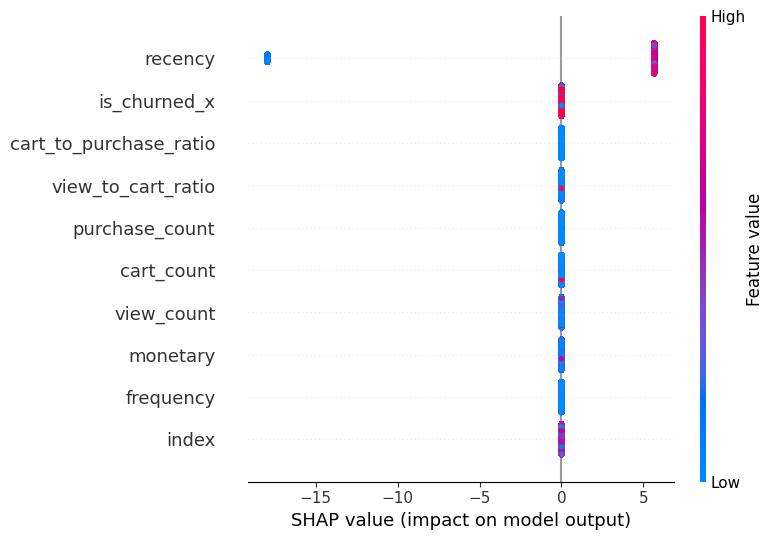

In [48]:
# Ensure all columns are numeric, and convert boolean columns to integers (0 and 1)
X_train_encoded = X_train_encoded.apply(pd.to_numeric, errors='coerce').fillna(0)
X_test_encoded = X_test_encoded.apply(pd.to_numeric, errors='coerce').fillna(0)

# Specifically convert boolean columns to integers (0 and 1)
X_train_encoded['is_churned_x'] = X_train_encoded['is_churned_x'].astype(int)
X_test_encoded['is_churned_x'] = X_test_encoded['is_churned_x'].astype(int)

# Re-train the XGBoost model using the encoded data
models["XGBoost"].fit(X_train_encoded, y_train)

# Create SHAP explainer for XGBoost model
explainer = shap.Explainer(models["XGBoost"], X_train_encoded)

# Get SHAP values for the test set
shap_values = explainer(X_test_encoded)

# Visualize the SHAP values with a summary plot
shap.summary_plot(shap_values, X_test_encoded)
